<a href="https://colab.research.google.com/github/helonayala/pinn/blob/main/01_DeepVIV_sec21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics-informed Artificial Neural Network

Author: Helon Ayala, October 2020

Based on: https://github.com/maziarraissi/DeepVIV

(translated to Keras layer subclassing and tf 2.0)

# Quick description

In this notebook we reproduce the results of the paper 

* Raissi, Maziar, Zhicheng Wang, Michael S. Triantafyllou, and George Em Karniadakis."Deep learning of vortex-induced vibrations." Journal of Fluid Mechanics 861 (2019): 119-137.

in particular Section 2.1. Please refer to the paper for a detailed description of the method and case study. In the following we restrict to the information needed for the notebook to be self-contained.

# Problem definition

In summary, we will use the Physics-informed artificial neural networks (PINNs) for solving the forward and inverse problems related to the dynamics of a mass-spring-damper of the form

$$
\rho \ddot x (t) + b \dot x (t) + k x (t) = f (t)
$$

where the terms are described as follows
* $\rho, b, k$: inertia, viscous friction, and rigidity, respectively;
* $x(t)$: displacement;
* $f(t)$: sum of external forces

(please note I exchanged $\eta$ to $x$ if you compare to the notation used in the original paper)

On one hand, the forward problem relates to solving numerically the 2nd order ODE described in the EOM given. On the other hand, the inverse problem is related to inferring the parameters of the system: $\rho, b,k$

# Assumptions

We work under the assumptions that
* we know the time series $[x(t),f(t)]$, and
* we know the constitutive model of the system under study (thus, PINN).

# Imports and definitions 


In [1]:
#@title
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# progress bar for model.fit function
import tensorflow_addons as tfa
import tqdm

# set random seed for reproduction
tf.random.set_seed(42)

# initialize tqdm callback
tqdm_callback = tfa.callbacks.TQDMProgressBar(
  leave_epoch_progress = True,
  leave_overall_progress = True,
  show_epoch_progress = False,
  show_overall_progress = True,
  )


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow-addons in /home/helon/.local/lib/python3.8/site-packages (0.11.2)


# Load data and plot

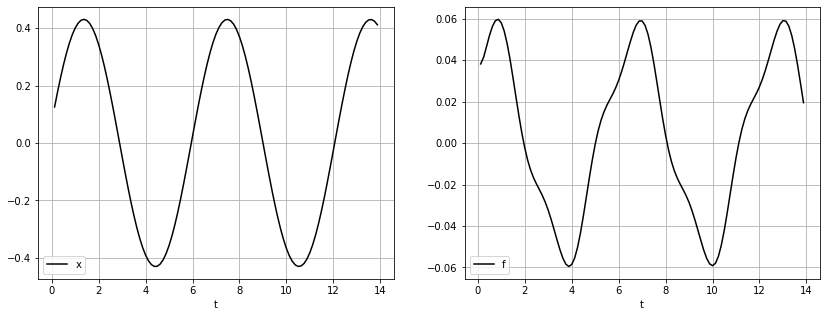

In [2]:
VIVdata = loadmat('data/VIV_displacement_lift_drag.mat')
# data from https://www.dropbox.com/s/gxeyasawxlj7nyu/Data.tar.gz?dl=0

x,f,t = VIVdata['eta_structure'], VIVdata['lift_structure'], VIVdata['t_structure']

N_train = t.shape[0] # how much data ?

# time series plots 
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(t,x,'k')
plt.legend('x'), plt.xlabel('t'), plt.grid()

plt.subplot(122)
plt.plot(t,f,'k')
plt.legend('f'), plt.xlabel('t'), plt.grid()
plt.show()

# Definition of the custom classes from tf.keras



In [3]:
# layer class
class tToXandF(tf.keras.layers.Layer):
    """
    Here we define the layers for the PINNs usign tf.keras and subclassing.

    Although semantically I think it would be clearer to use 2 layers objects (1 for the $\hat x = f(t) $ and 1 for the ODE/inverse problem), I had to use one layer for both PINN blocks. 

    I could not make it work with 2 different layers, probably because of the inner functioning of the tf.GradientTape function (to be investigated ...).
    """
    def __init__(self, layerWidth, actFcn, timevec, name="tToX", **kwargs):
        super(tToXandF, self).__init__(name=name, **kwargs)

        # rescale data
        self.minX = np.min(timevec)
        self.maxX = np.max(timevec)

        # instantiates hidden layers recursively
        self.denseList = []
        for nNeurons in layerWidth:
            self.denseList.append(
                tf.keras.layers.Dense(nNeurons, activation=actFcn)
            )  # hidden layers

        self.denseList.append(tf.keras.layers.Dense(1))  # output layer

        self.b = tf.Variable(0.05, name="b", trainable=True, dtype=tf.float32)
        self.k = tf.Variable(2.0, name="k", trainable=True, dtype=tf.float32)

    def call(self, t):

        with tf.GradientTape(
            persistent=True  # persistent for 2nd order derivative
        ) as tape:

            tape.watch(t)
            # part 1: calculate  t->x
            x = 1-2*(self.maxX - t) / (self.maxX - self.minX) # rescale [-1,1]
            for nLayers in range(self.denseList.__len__()):
                x = self.denseList[nLayers](x)

            # part 2a: calculate the gradients of x wrt t
            xp = tape.gradient(x, t)
            xpp = tape.gradient(xp, t)

            # part 2b: calculate the EOM
            f = 2.0 * xpp + self.b * xp + self.k * x

        return x, f

# model class
class PINN(tf.keras.Model):
    def __init__(self,timevec, layerWidth=10 * [32], actFcn=tf.sin, name="PINN", **kwargs):
        super(PINN, self).__init__(name=name, **kwargs)

        self.tToXandF = tToXandF(layerWidth=layerWidth, actFcn=actFcn, timevec= timevec)

    def call(self, t):
        return self.tToXandF(t)

# Callbacks for watching variables
class VariableValue(tf.keras.callbacks.Callback):
    def __init__(self, vars_to_track):
        super(VariableValue, self).__init__()
        self.vars_to_track = vars_to_track
        self.valueList = [] # list with all variables tracked (each epoch is an element)
    def on_epoch_begin(self, epoch, logs):
        tftensor2np = [x.numpy() for x in self.vars_to_track] # convert tf.tensor to list of numpy
        self.valueList.append(tftensor2np) # append for tracking
    # def get_value(self):
    #     """Return the variable values."""
    #     return self.valueList

# Instantiate PINN model and define hyperparameters

In [4]:
# default parameters are the same as DeepVIV paper
mdl = PINN(timevec = t)  

# learning rate and number of epochs
lrvec = np.array([1e-3, 1e-4, 1e-5, 1e-6])
epvec = np.array([2e3, 3e3, 3e3, 2e3], dtype="int32")

# callback - variables to watch
varList = [mdl.tToXandF.b, mdl.tToXandF.k]


# Train model

In [5]:
nTrain = lrvec.shape[0]
history = []
clbkVarValue = []
for i in range(nTrain):
    print("Learning rate:", lrvec[i])

    clbkVarValue.append(VariableValue(varList)) # instantiate callback (for saving identified values)

    mdl.compile(
        tf.keras.optimizers.Adam(learning_rate=lrvec[i]), loss="mse", metrics="mse"
    )
    history.append(
        mdl.fit(
            x=t,
            y=[x, f],
            epochs=epvec[i],
            batch_size=N_train,
            verbose=0,
            callbacks=[tqdm_callback, clbkVarValue[i]],
            )
        )

mdl.summary()


Training:   0%|           0/2000 ETA: ?s,  ?epochs/sLearning rate: 0.001
Training: 100%|██████████ 2000/2000 ETA: 00:00s,  287.93epochs/s
Training:   0%|           0/3000 ETA: ?s,  ?epochs/sLearning rate: 0.0001
Training: 100%|██████████ 3000/3000 ETA: 00:00s,  295.70epochs/s
Training:   0%|           0/3000 ETA: ?s,  ?epochs/sLearning rate: 1e-05
Training: 100%|██████████ 3000/3000 ETA: 00:00s,  290.28epochs/s
Training:   0%|           0/2000 ETA: ?s,  ?epochs/sLearning rate: 1e-06
Training: 100%|██████████ 2000/2000 ETA: 00:00s,  282.46epochs/sModel: "PINN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tToX (tToXandF)              multiple                  9603      
Total params: 9,603
Trainable params: 9,603
Non-trainable params: 0
_________________________________________________________________



# Plot training convergence

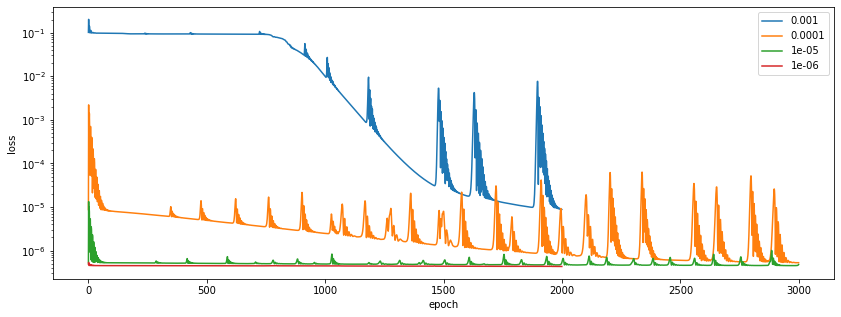

In [6]:
plt.figure(figsize=[14,5])
for i in range(nTrain):
    plt.plot(history[i].history['loss'])
plt.semilogy(), plt.legend(lrvec), plt.ylabel('loss'), plt.xlabel('epoch')
plt.show()


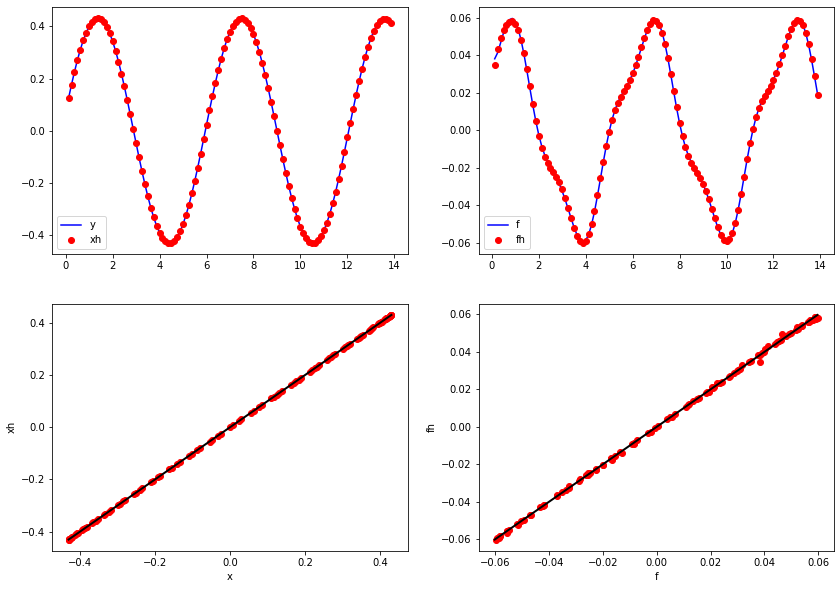

In [7]:
xh, fh = mdl.predict(t)

plt.figure(figsize=[14, 10])
plt.subplot(221)
plt.plot(t, x, "b-", t, xh, "ro")
plt.legend(["y", "xh"])
plt.subplot(223)
plt.plot(x,xh, "ro")
xmin, ymax = (np.min([x.min(),xh.min()]),np.max([x.max(),xh.max()]))
plt.plot(np.array([xmin,ymax]),np.array([xmin,ymax]), color = 'black', linewidth = 2) # this is just a 45º line
plt.xlabel('x'), plt.ylabel('xh')

plt.subplot(222)
plt.plot(t, f, "b-", t, fh, "ro")
plt.legend(["f", "fh"])
plt.subplot(224)
plt.plot(f,fh, "ro")
xmin, ymax = (np.min([f.min(),fh.min()]),np.max([f.max(),fh.max()]))
plt.plot(np.array([xmin,ymax]),np.array([xmin,ymax]), color = 'black', linewidth = 2) # this is just a 45º line
plt.xlabel('f'), plt.ylabel('fh')

plt.show()


# Parameter identification analysis

Values identified for the ODE (rho = 2.0, b = 0.0840, k = 2.2020 are the real values)
bhat: 0.084378 ( 0.450244 % error ) | khat: 2.201468 ( 0.024139 % error )


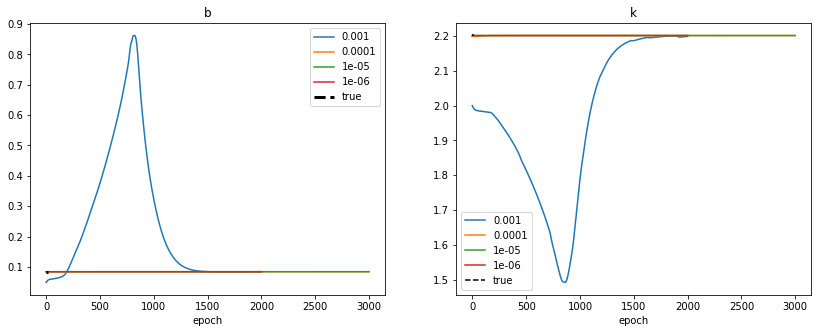

In [8]:

btrue = 0.084
ktrue = 2.2020
print("Values identified for the ODE (rho = 2.0, b = %0.4f, k = %0.4f are the real values)" % (btrue, ktrue))
print("bhat: %f ( %f %% error ) | khat: %f ( %f %% error )" % (mdl.tToXandF.b.numpy(), np.abs((btrue - mdl.tToXandF.b.numpy())/btrue * 100 ), mdl.tToXandF.k.numpy(), np.abs((ktrue - mdl.tToXandF.k.numpy())/ktrue * 100 )))

plt.figure(figsize=[14, 5])
plt.subplot(121)
leg = lrvec.tolist()
leg.append('true')
for i in range(nTrain):
    hatMatrix = np.array(clbkVarValue[i].valueList)
    plt.plot(hatMatrix[:,0:1])
plt.plot(t,np.ones(t.shape)*btrue,'k--',linewidth = 3)
plt.xlabel('epoch'), plt.legend(leg), plt.title('b')

plt.subplot(122)
for i in range(nTrain):
    hatMatrix = np.array(clbkVarValue[i].valueList)
    plt.plot(hatMatrix[:,1:])
plt.plot(t,np.ones(t.shape)*ktrue,'k--', )
plt.xlabel('epoch'), plt.legend(leg), plt.title('k')
plt.show()